In [1]:
import numpy as np
import jax

In [2]:
import matplotlib.pyplot as plt

In [3]:
np.random.normal(0, 1, size=(64,64,64)).mean()

0.0003770283811065178

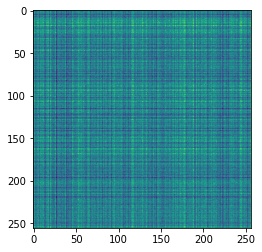

In [4]:
plt.imshow(np.random.rand(256,256) @ np.random.rand(256, 256))

In [5]:
#ra = r(ts, ts)
#rb = r(ts)
#rv = np.random.rand(ts)
#rp = rv / rv.sum()

In [6]:
ts = 3 # 3

def r(x, y=None, z=None):
    if y is None:
        return np.random.randn(x)
    elif z is None:
        return np.random.randn(x, y)
    else:
        return np.random.randn(x, y, z)

In [418]:
# create some random matrices / vectors for testing 
target = r(ts)
noise = r(ts) # random vector
params = r(ts, ts) # random matrix 

In [419]:
def mult(a, b):
    result = a @ b
    print(f'multiplying {a.shape} @ {b.shape} -> {result.shape}')
    return result

In [420]:

print(f'params: {params}')
print(f'noise: {noise}')
print(f'mult( params, noise ) : {mult( params, noise )}')
print(np.alltrue( np.array( [ params[0] @ noise, params[1] @ noise, params[2] @ noise ] ) == mult( params, noise ) ))
print(f'mult( noise, params ) : {mult( noise, params )}')
print(np.alltrue((noise[0] * params[0] + noise[1] * params[1] + noise[2] * params[2]) == mult( noise, params )))
mult( params.T, noise )
#print(f'mult( [noise,noise,noise], params ) : {mult( np.array([noise,noise,noise]), params )}')

params: [[ 1.46281554  0.76132341  0.14131935]
 [ 0.77901373 -0.27106439 -0.28211875]
 [ 0.93381733  2.55012479 -0.49562185]]
noise: [-0.30263538  0.58475077 -1.53806724]
multiplying (3, 3) @ (3,) -> (3,)
mult( params, noise ) : [-0.21487395  0.03965538  1.970881  ]
multiplying (3, 3) @ (3,) -> (3,)
True
multiplying (3,) @ (3, 3) -> (3,)
mult( noise, params ) : [-1.42344472 -4.31117191  0.55456235]
multiplying (3,) @ (3, 3) -> (3,)
True
multiplying (3, 3) @ (3,) -> (3,)


array([-1.42344472, -4.31117191,  0.55456235])

In [421]:
def test_auto_func(ga, b, target):
    first_p = (ga @ b)**2
    normed = first_p / first_p.sum()
    return ((normed - target)**2).mean()

In [422]:
test_auto_func_bound = lambda ga: test_auto_func(ga, noise, target)

In [503]:
def test_simple_func(a, b):
    mult = (a @ b)
    msq = mult**2
    arr_sum = msq.sum()
    mean = arr_sum / mult.shape[0]
    return mean

In [504]:
test_simple_func_bound = lambda ga: test_simple_func(ga, noise)

In [505]:
jax.value_and_grad(test_simple_func_bound)(params)

(DeviceArray(1.3107052, dtype=float32),
 DeviceArray([[ 0.04335231, -0.08376514,  0.22032706],
              [-0.00800074,  0.015459  , -0.04066174],
              [-0.3976389 ,  0.76831615, -2.0208983 ]], dtype=float32))

In [506]:
finite_diff_value_and_grad(test_simple_func_bound)(params)

(1.310705089016943,
 array([[ 0.04335234, -0.08376502,  0.22032785],
        [-0.00800072,  0.01545912, -0.04066098],
        [-0.39763885,  0.76831623, -2.02089755]]))

In [509]:
def test_simple_grad_backprop(a, b):
    mult = (a @ b)
    msq = mult**2
    arr_sum = msq.sum()
    mean = arr_sum / mult.shape[0]
    #print(sec_grad - finite_diff_value_and_grad(test_simple_func_bound)(params)[1])

    # product rule
    # d/dx (a * b) = da/dx * b + db/dx * a
    # x^2 * x^3 >> 5x^4 >> 2x*x^3 + 3x^2 * x^2
    # chain rule
    # dh/dx = dh/du * du/dx
    # u = f(x)
    # h = g(f(x)) or g(u)
    
    # u = ((a @ b) ** 2).sum()
    dmean_darr_sum = 1 / mult.shape[0]
    darr_sum_dmsq = dmean_darr_sum * 1 
    dmsq_dmult = darr_sum_dmsq * (2 * mult)
    d_mult_da = np.outer(dmsq_dmult, b)
    
    return mean, d_mult_da

In [510]:
test_simple_grad_backprop(params, noise)

(1.310705089016943,
 array([[ 0.04335231, -0.08376514,  0.22032706],
        [-0.00800075,  0.01545901, -0.04066176],
        [-0.39763888,  0.76831611, -2.02089834]]))

In [516]:
def test_auto_func_grad_backprop(a, b, target):
    mult = (a @ b)
    sq = mult**2
    squm = sq.sum()
    normed = sq / squm
    delt = normed - target
    deltsq = delt**2
    deltsqum = deltsq.sum()
    mse = deltsqum / deltsq.shape[0]
    
    dmse_ddeltsqum = 1 / deltsq.shape[0]
    ddeltsqum_ddeltsq = dmse_ddeltsqum
    ddeltsq_ddelt = ddeltsqum_ddeltsq * 2 * delt
    ddelt_dnormed = ddeltsq_ddelt * 1 # ? target matter?
    #dsqum_dsq = 
    dnormed_dsqum = ddelt_dnormed * (1 / squm)
    # need dsqum ? 
    dsq_dmult = dnormed_dsqum * 2 * mult
    dmult_da = np.outer(dsq_dmult, b)
    
    return mse, dmult_da
    

In [517]:
test_auto_func_grad_backprop(params, noise, target)

(2.99263539913861,
 array([[-0.04001982,  0.07732612, -0.20339054],
        [-0.00962529,  0.01859794, -0.04891807],
        [-0.06049993,  0.1168977 , -0.30747548]]))

In [513]:
jax.value_and_grad(test_auto_func_bound)(params)

(DeviceArray(2.9926353, dtype=float32),
 DeviceArray([[-0.04608664,  0.0890484 , -0.23422359],
              [-0.00850564,  0.01643456, -0.04322774],
              [-0.00485342,  0.00937776, -0.02466629]], dtype=float32))

In [433]:
def finite_diff_value_and_grad(func):
    def grad_f(ga):
        eps = 0.000001
        grad = np.zeros(ga.shape)
        for i in range(ga.shape[0]):
            for j in range(ga.shape[0]):
                delta_mat = np.zeros(ga.shape)
                delta_mat[i][j] = eps
                bumped = ga + delta_mat
                grad[i][j] = (func(bumped) - func(ga)) / eps
        return grad
    return lambda x: (func(x), grad_f(x))

In [434]:
def finite_diff_value_and_grad_v2(func):
    def grad_f(ga):
        eps = 0.000001
        grad = np.zeros(ga.size)
        bumped = ga.flatten()
        for i in range(ga.size):
            bumped[i] += eps
            grad[i] = (func(bumped.reshape(ga.shape)) - func(ga)) / eps
            bumped[i] -= eps
        return grad.reshape(ga.shape)
    return lambda x: (func(x), grad_f(x))

In [440]:
#finite_diff_value_and_grad(ra, rb, rp, test_auto_func_bound)
finite_diff_value_and_grad_v2(test_auto_func_bound)(params)

(2.99263539913861,
 array([[-0.04608667,  0.0890483 , -0.2342244 ],
        [-0.00850561,  0.01643469, -0.04322693],
        [-0.00485343,  0.00937776, -0.02466633]]))

In [436]:
def optimize(params, grad_method, func):
    weights = params.copy()
    for i in range(1000):
        loss, grad_val = grad_method(func)(weights)
        weights -= 0.03 * grad_val
        if (i % 100 == 0):
            print(f'step {i}: loss: {loss}')

In [437]:
optimize(params, jax.value_and_grad, test_auto_func_bound)

step 0: loss: 2.9926352500915527
step 100: loss: 2.2704389095306396
step 200: loss: 2.2534871101379395
step 300: loss: 2.251239538192749
step 400: loss: 2.250563621520996
step 500: loss: 2.25030255317688
step 600: loss: 2.2501912117004395
step 700: loss: 2.2501416206359863
step 800: loss: 2.250119209289551
step 900: loss: 2.2501089572906494


In [438]:
#%%timeit
optimize(params, finite_diff_value_and_grad, test_auto_func_bound)

step 0: loss: 2.99263539913861
step 100: loss: 2.270438832122618
step 200: loss: 2.2534869036122633
step 300: loss: 2.2512395563802436
step 400: loss: 2.250563578819088
step 500: loss: 2.250302484804432
step 600: loss: 2.25019117125837
step 700: loss: 2.2501416480643646
step 800: loss: 2.250119190943966
step 900: loss: 2.250108918642726


In [439]:
#%%timeit
optimize(params, finite_diff_value_and_grad_v2, test_auto_func_bound)

step 0: loss: 2.99263539913861
step 100: loss: 2.270438832122618
step 200: loss: 2.2534869036122633
step 300: loss: 2.2512395563802436
step 400: loss: 2.250563578819088
step 500: loss: 2.250302484804432
step 600: loss: 2.25019117125837
step 700: loss: 2.2501416480643646
step 800: loss: 2.250119190943966
step 900: loss: 2.250108918642726
